# Machine Learning Para Prevenção a Fraude

# Introdução 

Na sociedade atual, um dos crimes mais praticados são as fraudes, que são atividades em que criminosos se passam por outra pessoa para usufruir de bens para si mesmo, sendo que ela se estende desde cartão de crédito até falsificação de cheques. Uma das tecnologias empregadas atualmente para o combate de fraude é a utilização de Machine Learning Supervisionado, técnica estatística que consiste em construir um modelo que consiga prever o valor de um rótulo a partir de um conjunto de variáveis preditoras. Neste projeto, será construida um Modelo de Aprendizado de Máquina Supervisionado que tem como objetivo predizer se uma transação de cartão de crédito é fraude ou não. 

# Conhecendo o conjunto de dados 

In [2]:
#Importação dos pacotes que serão utilizados
import pandas                     as pd
import seaborn                    as sns
import matplotlib.pyplot          as plt
import numpy                      as np
from imblearn.under_sampling      import NearMiss
from sklearn.model_selection      import train_test_split
from collections                  import Counter
from sklearn.compose              import ColumnTransformer
from sklearn.preprocessing        import OneHotEncoder
from sklearn.model_selection      import cross_val_score
from sklearn.naive_bayes          import GaussianNB
from sklearn.linear_model         import LogisticRegression
from sklearn.ensemble             import RandomForestClassifier 
from sklearn.tree                 import DecisionTreeClassifier
from sklearn.neighbors            import KNeighborsClassifier 
from sklearn.preprocessing        import StandardScaler
from sklearn.tree                 import DecisionTreeClassifier
from sklearn.metrics              import classification_report,roc_curve, auc,confusion_matrix,ConfusionMatrixDisplay

Inicialmente, é possivel conhecer o conjunto de dados observando as 6 primeiras linhas. Além disso, é obtido em seguida o número de linhas e o número de colunas do conjunto de dados. 

In [4]:
dados=pd.read_csv("card_transdata.csv")
dados.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [54]:
dados.shape

(1000000, 8)

Pode-se observar que o conjunto de dados é formado por 1 milhão de linhas e 8 colunas, em que o significado de cada coluna é dado por: 

**distance_from_home** = A distância de casa de onde ocorreu a transação

**distance_from_last_transaction** - A distância da última transação ocorrida

**ratio_to_median_purchase_price** - Proporção entre a transação do preço de compra e o preço de compra mediano

**repeat_retailer** - A transação ocorreu no mesmo varejista

**used_chip** - A transação é através de chip (cartão de crédito)

**used_pin_number** - A transação ocorre usando número da senha 

**online_order** - A transação é um pedido online

**fraud** - Se a transação é fraudulenta ou não

# Pré Processamento

Do conjunto de dados, é importante verificar se as o Pandas está tratando o tipo das variáveis corretamente

In [55]:
dados.dtypes

distance_from_home                float64
distance_from_last_transaction    float64
ratio_to_median_purchase_price    float64
repeat_retailer                   float64
used_chip                         float64
used_pin_number                   float64
online_order                      float64
fraud                             float64
dtype: object

In [7]:
dados['Tipo de Fraude'] = np.where(dados['fraud'] == 1, 'Fraude', 'Sem Fraude')

Tem-se que todas as variáveis estão no formato float64, indicando que os dados estão no formato correto. Ademais, é interessante observar se o conjunto de dados possui dados faltantes.

In [58]:
dados.isnull().sum()/len(dados)

distance_from_home                0.0
distance_from_last_transaction    0.0
ratio_to_median_purchase_price    0.0
repeat_retailer                   0.0
used_chip                         0.0
used_pin_number                   0.0
online_order                      0.0
fraud                             0.0
Tipo de Fraude                    0.0
dtype: float64

Verifica-se que o conjunto de dados está limpo, sem a presença de dados faltantes.

# Análise Exploratória

Com o objetivo de se obter informações sobre a estatísticas sumárias das variáveis do conjunto de dados, é interessante realizar uma análise descritiva das variáveis do conjunto de dados. Dessa forma, tem-se que as estatísticas sumárias das variáveis é dada por: 



In [59]:
dados.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


Da tabela de estatística sumária, é possível extrair alguns insights interessantes. Por exemplo, observa-se a presença de possíveis pontos outliers nas variáveis distance_from_home, distance_from_home e distance_from_home. Por exemplo, da variável distance_from_home tem-se que o terceiro quartil é de 25.74, porém observa-se o valor máximo que a variável assume é de 10632.72. Para a variável distance_from_home observa-se o terceiro quartil de 3.35, porém tem-se que o ponto máximo é de 11851.10. Além disso, pode-se observar para as variáveis quantitativas de distâncias e de proporção entre a transação do preço de compra e o preço de compra mediano que há uma discrepância entre média e mediana, por exemplo, para a variável distance_from_home observa-se uma média de 26.62, porém uma mediana de apenas 9.96.

Além de conhecer as medidas sumárias das variáveis, é interessante conhecer quantas das transações são de fato fraude através de um gráfico de barra.

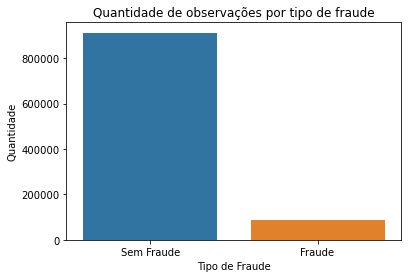

In [60]:
sns.countplot(x="Tipo de Fraude",data=dados)
plt.title("Quantidade de observações por tipo de fraude")
plt.ylabel("Quantidade")
plt.show()

In [61]:
dados.groupby("Tipo de Fraude")["Tipo de Fraude"].count()/len(dados)*100

Tipo de Fraude
Fraude         8.7403
Sem Fraude    91.2597
Name: Tipo de Fraude, dtype: float64

Do gráfico de barra, verifica-se que a maioria das transações não ocorre fraude, sendo que a ocorrência de fraude corresponde a apenas 8.7% das observações. Esse percentual indica que o conjunto de dados está desabalanceado, isto é, tem-se muito mais observações de uma classe em relação a outra, para a construção dos modelos de Machine Learning deverá ser realizada algum tratamento para lidar com o desbalanceamento. 
Analisando as variáveis do Dataset, pode-se questionar se as variáveis estão correlacionadas, criando um correlograma.

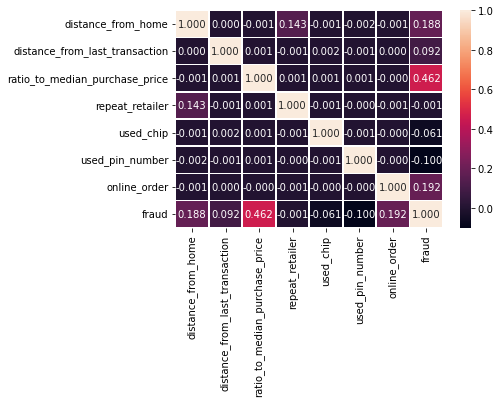

In [62]:
correlacao=dados.corr()
plot = sns.heatmap(correlacao, annot = True,fmt=".3f", linewidths=.6)
plot

O coeficiente de correlação varia entre -1 e 1. Valores de correlação próximos a 1 indica que quando uma variável aumenta a outra tende a aumentar, ocorrendo o processo inverso em valores de correlação próximos a -1. Porém, é importante frisar que correlação não está correlação com causa e efeito. Do correlograma, é possive observar que não há nenhuma forte relação linear entre as variáveis.  

Então, pode-se conhecer a distribuição dos valores das variáveis quantitativas de distância e de proporção entre a transação do preço de compra e o preço de compra medianoatravés de boxplot e histogramas.

Text(0.5, 1.0, 'Histograma de relação ao preço médio de compra')

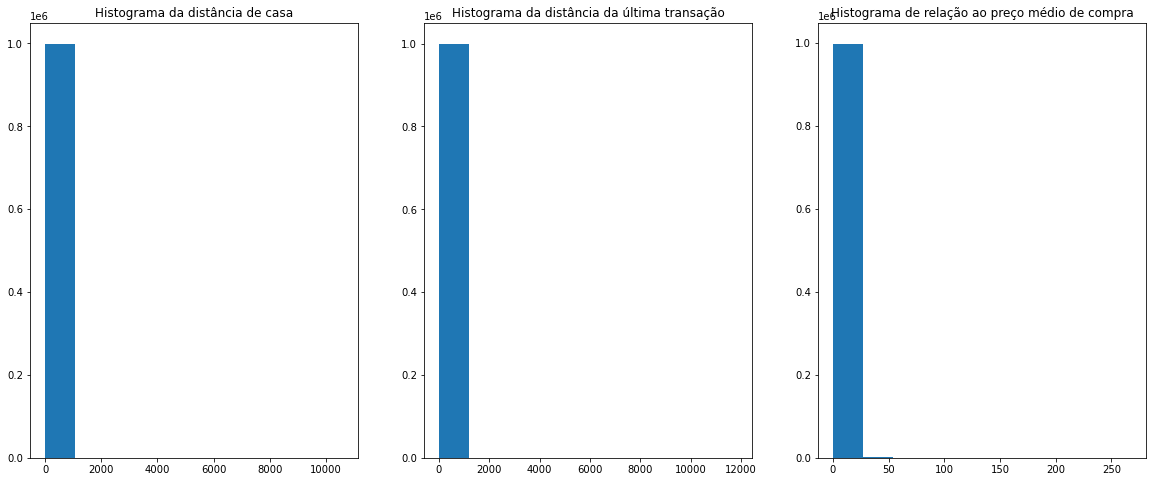

In [63]:
fig,(axes1,axes2,axes3)=plt.subplots(1,3,figsize=(20,8))
axes1.hist(dados["distance_from_home"])
axes1.set_title("Histograma da distância de casa")
axes2.hist(dados["distance_from_last_transaction"])
axes2.set_title("Histograma da distância da última transação")
axes3.hist(dados["ratio_to_median_purchase_price"])
axes3.set_title("Histograma de relação ao preço médio de compra")

Do histograma, pode-se observar que para as variáveis de distância de casa e da última transação os valores se concentram no intervalo de 0 a 1500. Para variável ratio_to_median_purchase_price, observa-se uma grande concentração no intervalo de 0 a 25.
Os boxplots dessas variáveis, separado por tipo de fraude, é dado por: 

Text(0.5, 1.0, 'Distribuição relação ao preço médio de compra por tipo de fraude')

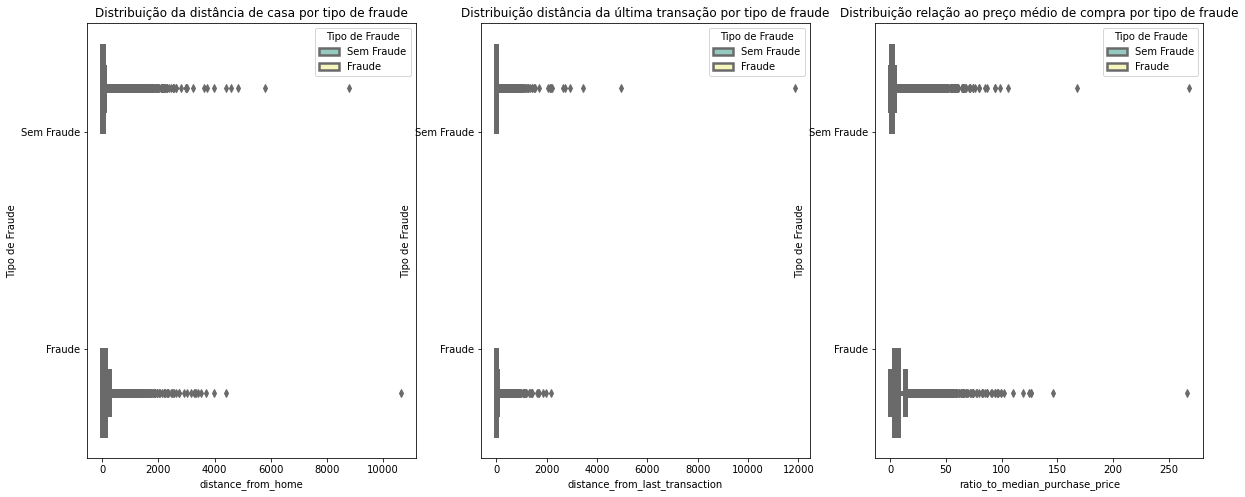

In [64]:
fig,axes=plt.subplots(1,3,figsize=(20,8))
sns.boxplot( x = "distance_from_home", y ="Tipo de Fraude",data = dados,ax=axes[0],
                  hue = "Tipo de Fraude",color="Tipo de Fraude",linewidth=5, palette = "Set3")
axes[0].set_title("Distribuição da distância de casa por tipo de fraude")
sns.boxplot( x = "distance_from_last_transaction", y ="Tipo de Fraude",data = dados,ax=axes[1],
                  hue = "Tipo de Fraude",color="Tipo de Fraude",linewidth=5, palette = "Set3")
axes[1].set_title("Distribuição distância da última transação por tipo de fraude")
sns.boxplot( x = "ratio_to_median_purchase_price", y ="Tipo de Fraude",data = dados,ax=axes[2],
                  hue = "Tipo de Fraude",color="Tipo de Fraude",linewidth=5, palette = "Set3")
axes[2].set_title("Distribuição relação ao preço médio de compra por tipo de fraude")

Para a variável distância de casa nota-se a presença de pontos outliers, com presença de um ponto superior a 10000 na presença de fraude. Para a variável distância da última transação, nota-se a presença de pontos outliers tanto na presença quanto na ausência de fraude, porém nota-se que as transações que não ocorre fraude alcança valores mais altos em relação as transações que não ocorre. 

Além de verificar as distribuiçoes das variáveis quantitativas por meio do boxplot, é possivel construir gráficos de barra para analisar possiveis diferenças nas médias das variáveis em relação a presença ou não de fraude. Para as variáveis quantitativas distance_from_home, distance_from_last_transaction e ratio_to_median_purchase_price é analisada a média por tipo de transação. Enquanto que para as variáveis qualitativas é possivel obter os valores por tipo de fraude de uso de chip e senha númerica, o percentual de compras online e se o varejista é repetido. 

Text(0.5, 1.0, 'Percentual de uso de senha numérica por tipo de fraude')

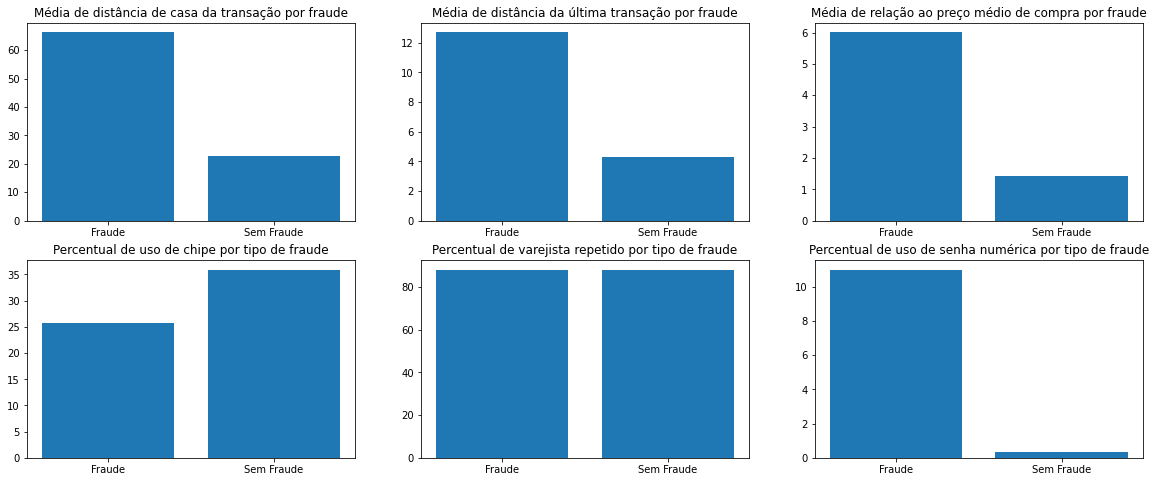

In [10]:
fig,axes=plt.subplots(2,3,figsize=(20,8))
axes[0,0].bar(dados.groupby("Tipo de Fraude")["distance_from_home"].mean().index,dados.groupby("Tipo de Fraude")["distance_from_home"].mean().values)
axes[0,0].set_title("Média de distância de casa da transação por fraude")
axes[0,1].bar(dados.groupby("Tipo de Fraude")["distance_from_last_transaction"].mean().index,dados.groupby("Tipo de Fraude")["distance_from_last_transaction"].mean().values)
axes[0,1].set_title("Média de distância da última transação por fraude")
axes[0,2].bar(dados.groupby("Tipo de Fraude")["ratio_to_median_purchase_price"].mean().index,dados.groupby("Tipo de Fraude")["ratio_to_median_purchase_price"].mean().values)
axes[0,2].set_title("Média de relação ao preço médio de compra por fraude")
axes[1,0].bar(dados.groupby("Tipo de Fraude")["used_chip"].mean().index,dados.groupby("Tipo de Fraude")["used_chip"].mean().values*100)
axes[1,0].set_title("Percentual de uso de chipe por tipo de fraude")
axes[1,1].bar(dados.groupby("Tipo de Fraude")["repeat_retailer"].mean().index,dados.groupby("fraud")["repeat_retailer"].mean().values*100)
axes[1,1].set_title("Percentual de varejista repetido por tipo de fraude")
axes[1,2].bar(dados.groupby("Tipo de Fraude")["used_pin_number"].mean().index,dados.groupby("fraud")["used_pin_number"].mean().values*100)
axes[1,2].set_title("Percentual de uso de senha numérica por tipo de fraude")

Text(0.5, 1.0, 'Percentual de compras online por tipo de fraude')

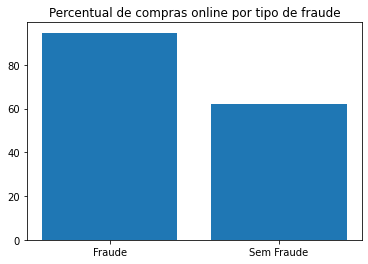

In [14]:
plt.bar(dados.groupby("Tipo de Fraude")["online_order"].mean().index,dados.groupby("Tipo de Fraude")["online_order"].mean().values*100)
plt.title("Percentual de compras online por tipo de fraude")

Dos gráficos, é possivel observar que para as variáveis quantitativas a média das transações que ocorre fraude é aproximadamente três vezes maior em relação as transações que não ocorre, indicando que em média quanto mais distante de casa e da última transação, e quanto maior o preço médio de compra mais indicio de que a transação é fraudulenta. Para a variável de uso de chipe, observa-se que as transações que não ocorre fraude assume valor 40% maior em relação quando não ocorre fraude. Para a variável de varejista repetido, é possivel observar que não existe nenhuma diferença significativa. Enquanto que é possivel observar extremamente significativa no uso de pin, que nas transações que ocorre o evento tem uma média dez maior em relação a que não ocorre. Para a variável de compras online, verifica-se que na ocorrência de transações fraudulentas, 80% das transações são feitas de forma online. 

# Lidando com desbalanceamento das classes

Da Análise Exploratória, foi visto que as transações não fraudulentas corresponde a 90% das observações. A presença de uma classe majoritária pode fazer com que os modelos de Machine Learning criados caiam no paradoxo da Acurácia, isto é, a acurácia vai ter uma valor alto, pois conseguirá prever o valor correto das observações da classe majoritária, porém não terá boa perfomance ao lidar com as classes minoritárias(fraudes).

Uma das abordagens para lidar com o desbalanceamento é o undersampling que tem como objetivo reduzir a quantidade de observações da classe minoritária. Um dos algoritmos do undersampling é o NearMISS, que leverá a distância das observaçõoes da classe minoritária em relação a classe majoritária. 

Para a construção dos modelos de Machine Learning, os dados serão divididos em 70% das observações para treino do modelo e 30% das observações para teste, mas primeiro os dados são divididos em variáveis preditoras(X) e variáveis target(Y, que é relacionada a fraude). 

In [66]:
X=dados.iloc[:,0:7]
Y=dados.iloc[:,7]

In [67]:
x_treino,x_teste,ytreino,y_teste=train_test_split(X,Y,test_size=0.3,random_state=0)

In [68]:
nr=NearMiss()
X_near, Y_near= nr.fit_sample(x_treino, ytreino.ravel())

Após redução das observações da classe minoritária a partir do método NearMissa pode-se visualizar a distribuição das classes através de um gráfico de barras:

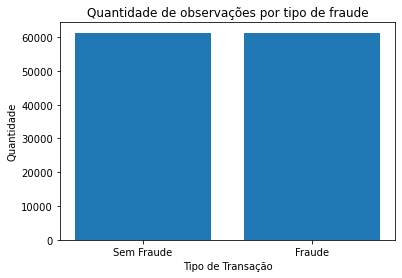

In [69]:
arr=np.array(Y_near)
valoresunicos,contagens = np.unique(arr,return_counts=True)
valores=["Sem Fraude","Fraude"]
plt.bar(valores,contagens)
plt.xlabel("Tipo de Transação")
plt.ylabel("Quantidade")
plt.title("Quantidade de observações por tipo de fraude")
plt.show()

# Construção do modelo 

Para a construção do modelo de prevenção a fraude, serão construidos utilizados os algortimos de Regressão Logistica, Naive Bayes, Árvore de Decisão e Random Forest. Com o objetivo de se controlar overfitting será utilizada a métrica da validação cruzada, que tem como objetivo treinar vários modelos com um conjunto de bases de teste e de treino. A métrica escolhida na validação cruzada será a acurácia, com a construção de 10 modelos para cada algoritmo, sendo que em seguida será calculada a média da acurácia para verificar qual algoritmo obteve melhor perfomance em média.

In [70]:
#Construção de listas para armazenar as acurácias dos modelos e a lista dos algortimos 
listaalgoritmos=[]
listaacuracia=[]

In [71]:
#Construção NaiveBayes
modelonaive=GaussianNB()
acuracia=cross_val_score(modelonaive,x_treino,ytreino,cv=15,scoring="accuracy")
listaacuracia.append(acuracia.mean())
listaalgoritmos.append("Naive Bayes")

In [72]:
#Construção do modelo de Regressão Logistica
modeloregressao=LogisticRegression(solver="lbfgs",max_iter=1000)
acuracia=cross_val_score(modeloregressao,x_treino,ytreino,cv=10,scoring="accuracy")
listaacuracia.append(acuracia.mean())
listaalgoritmos.append("Regressão Logistica")

In [73]:
modeloarvore=DecisionTreeClassifier(criterion="entropy")
acuracia=cross_val_score(modeloarvore,x_treino,ytreino)
listaacuracia.append(acuracia.mean())
listaalgoritmos.append("Arvore de Decisão")

In [74]:
# Construção do modelo de Random Forest
modelorandomforest=RandomForestClassifier(n_estimators=30,criterion="entropy")
acuracia=cross_val_score(modelorandomforest,x_treino,ytreino,cv=10,scoring="accuracy")
listaacuracia.append(acuracia.mean())
listaalgoritmos.append("Random Forest")

Construindo o modelo, pode-se obter uma tabela com o algoritmo e a acurácia por ordem decrescente de acurácia. 

In [80]:
dadosresultados=pd.DataFrame()
dadosresultados["Algoritmos"]=listaalgoritmos
dadosresultados["Acurácia"]=listaacuracia
dadosresultados=dadosresultados.sort_values(by="Acurácia",ascending=False)
dadosresultados

,Algoritmos,Acurácia
3,Random Forest,0.999989
2,Arvore de Decisão,0.999987
1,Regressão Logistica,0.958629
0,Naive Bayes,0.950591


Da tabela, pode-se observar que o modelo com maior acurácia foram os modelos baseados em árvore de decisão, principalmente o Random Forest com praticamente 100% de acurácia. Logo, é possivel prosseguir com a Modelagem treinando um modelo de Random Forest com os dados de treino e testando com dados de teste, dados que não foram vistos para construção dos modelos utilizados na validação cruzada. Com os dados de teste, é possivel obter a capacidade de generalização do modelo de Random Forest e obter as demais métricas do modelo, tais como, Recall, Precision, F1.

In [81]:
modelorandomforestfim=RandomForestClassifier(n_estimators=30,criterion="entropy")
modelorandomforest.fit(X_near, Y_near)

RandomForestClassifier(criterion='entropy', n_estimators=30)

In [82]:
resultadorandomforest=modelorandomforest.predict(x_teste)


# Avaliação do Modelo de Random Forest

Treinando o modelo, pode-se obter verificar a perfomance do mesmo comparando os rótulos previstos em relação aos dados de teste. Observando a matriz de métricas, pode-se observar que o modelo de Random Forest conseguiu uma boa perfomance, com um recall de 1 e uma precisão de 0.98 na classe 1, isto é, dos dados que o modelo classificou como fraude, 98% são de fato fraude. 

In [83]:
print(classification_report(y_teste,resultadorandomforest))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    273907
         1.0       0.98      1.00      0.99     26093

    accuracy                           1.00    300000
   macro avg       0.99      1.00      0.99    300000
weighted avg       1.00      1.00      1.00    300000



Em seguida, é possivel construir uma matriz de confusão que consiga verificar a perfomance do modelo por classe. Da matriz de confusão, verifica-se que o modelo todas as previsões para a classe, isto é, o modelo conseguiu classificar corretamente todos os casos que ocorre fraude. Para os casos que não ocorreu fraude, o modelo de Random Forest classificou incorretamente 536 de 273907 observações. 

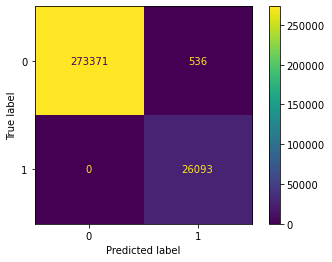

In [92]:
matriz_confusao=confusion_matrix(y_teste,resultadorandomforest)
matriz_confusao_disp=ConfusionMatrixDisplay(matriz_confusao)
matriz_confusao_disp.plot()
plt.show()

Outra métrica importante a ser verificada é a curva ROC, uma medida que varia de 0 a 1 e compara a taxa de verdadeiros positivos com falsos positivos. Quanto mais próximo de 1 for o valor da curva ROC, maior é a indicação de que as observações que o modelo classificou como positivas são, de fato, positivas. 
Da curva ROC a seguir, temos um valor de 0.999, dessa forma praticamente todos os casos que o modelo classificou como fraude são de fato fraude. 

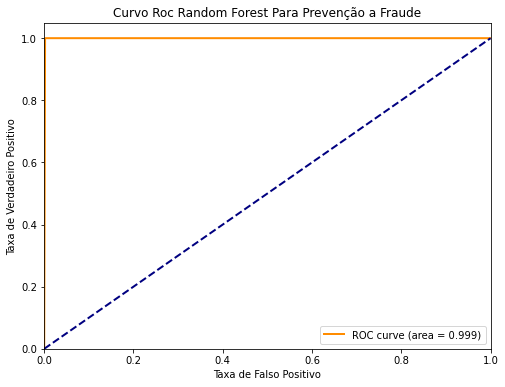

In [96]:
fpr, tpr, thresholds = roc_curve(y_teste,resultadorandomforest)
fpr,tpr,thresholds=roc_curve(y_teste,resultadorandomforest)
roc_auc=auc(fpr,tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0,1],[0,1],color="navy",lw=2,linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("Taxa de Falso Positivo")
plt.ylabel("Taxa de Verdadeiro Positivo")
plt.title("Curvo Roc Random Forest Para Prevenção a Fraude")
plt.legend(loc='lower right')
plt.show()

Portanto, tendo em vista as métricas de perfomance do modelo e a matriz de confusão, pode-se concluir que, no geral, o modelo de Random Forest obteve uma boa perfomance ao classificar uma transação como fraudulenta ou não.